# Crop Identification

### Imports

In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
import keras 
from keras.layers import Conv2D
from keras.models import Sequential
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Model
# import keras.preprocessing
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import cv2
import re
import random
random.seed(0)
np.random.seed(0)
# conda install albumentations
import albumentations as A

In [2]:
import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

./data\Crop_details.csv
./data\crop_images\jute\jute001a.jpeg
./data\crop_images\maize\maize001a.jpeg
./data\crop_images\rice\rice001a.jpeg
./data\crop_images\sugarcane\sugarcane0001a.jpeg
./data\crop_images\wheat\wheat0001a.jpeg
./data\kag2\jute\jute001a.jpeg
./data\kag2\maize\maize001a.jpeg
./data\kag2\rice\rice001a.jpeg
./data\kag2\sugarcane\sugarcane0001a.jpeg
./data\kag2\wheat\wheat0001a.jpeg
./data\some_more_images\some_more_images\jute\jute041a.jpg
./data\some_more_images\some_more_images\maize\maize041a.jpg
./data\some_more_images\some_more_images\rice\rice041a.jpg
./data\some_more_images\some_more_images\sugarcane\sugarcane041a.jpg
./data\some_more_images\some_more_images\Wheat\wheat041a.jpg
./data\test_crop_image\jute-field.jpg


Text(0.5, 1.0, 'wheat')

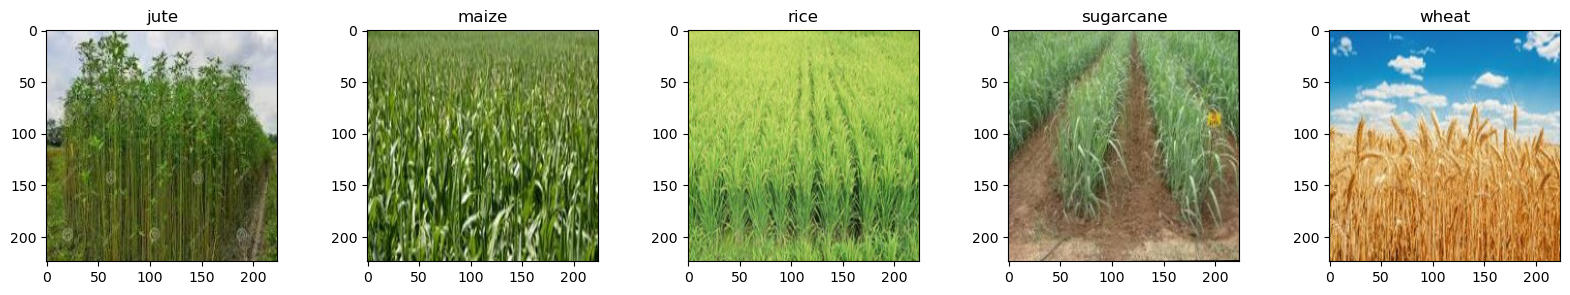

In [3]:
wheat = plt.imread("./data/kag2/wheat/wheat0004a.jpeg")
# wheat = plt.imread("./data/")
jute = plt.imread("./data/kag2/jute/jute005a.jpeg")
cane = plt.imread("./data/kag2/sugarcane/sugarcane0010arot.jpeg")
rice = plt.imread("./data/kag2/rice/rice032ahs.jpeg")
maize = plt.imread("./data/kag2/maize/maize003a.jpeg")
plt.figure(figsize=(20,3))
plt.subplot(1,5,1)
plt.imshow(jute)
plt.title("jute")
plt.subplot(1,5,2)
plt.imshow(maize)
plt.title("maize")
plt.subplot(1,5,3)
plt.imshow(rice)
plt.title("rice")
plt.subplot(1,5,4)
plt.imshow(cane)
plt.title("sugarcane")
plt.subplot(1,5,5)
plt.imshow(wheat)
plt.title("wheat")

### Create Training and testing data

In [6]:
jutepath = "./data/kag2/jute"
maizepath = "./data/kag2/maize"
ricepath = "./data/kag2/rice"
sugarcanepath = "./data/kag2/sugarcane"
wheatpath = "./data/kag2/wheat"

jutefilename = os.listdir(jutepath)
maizefilename = os.listdir(maizepath)
ricefilename = os.listdir(ricepath)
sugarcanefilename = os.listdir(sugarcanepath)
wheatfilename = os.listdir(wheatpath)


In [10]:
X= []

for fname in jutefilename:
    X.append([os.path.join(jutepath,fname),0])
for fname in maizefilename:
    X.append([os.path.join(maizepath,fname),1])
for fname in ricefilename:
    X.append([os.path.join(ricepath,fname),2])
for fname in sugarcanefilename:
    X.append([os.path.join(sugarcanepath,fname),3]) 
for fname in wheatfilename:
    X.append([os.path.join(wheatpath,fname),4])  
X = pd.DataFrame(X,columns = ['path','labels'])    

X.head()
X.tail()

,path,labels
799,./data/kag2/wheat\wheat039arot.jpeg,4
800,./data/kag2/wheat\wheat040a.jpeg,4
801,./data/kag2/wheat\wheat040ahf.jpeg,4
802,./data/kag2/wheat\wheat040ahs.jpeg,4
803,./data/kag2/wheat\wheat040arot.jpeg,4


In [16]:
onehotEncoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
onehotLabel = pd.DataFrame(onehotEncoder.fit_transform(X[['labels']]),dtype = 'float64',columns = ['label0','label1','label2','label3','label4'])
label_X = X.copy()
X = pd.concat([X,onehotLabel],axis = 1)
new_X = X.drop(['labels'],axis = 1)

In [43]:
new_X

,path,label0,label1,label2,label3,label4
0,./data/kag2/jute\jute001a.jpeg,1.0,0.0,0.0,0.0,0.0
1,./data/kag2/jute\jute001ahf.jpeg,1.0,0.0,0.0,0.0,0.0
2,./data/kag2/jute\jute001ahs.jpeg,1.0,0.0,0.0,0.0,0.0
3,./data/kag2/jute\jute001arot.jpeg,1.0,0.0,0.0,0.0,0.0
4,./data/kag2/jute\jute002a.jpeg,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
799,./data/kag2/wheat\wheat039arot.jpeg,0.0,0.0,0.0,0.0,1.0
800,./data/kag2/wheat\wheat040a.jpeg,0.0,0.0,0.0,0.0,1.0
801,./data/kag2/wheat\wheat040ahf.jpeg,0.0,0.0,0.0,0.0,1.0
802,./data/kag2/wheat\wheat040ahs.jpeg,0.0,0.0,0.0,0.0,1.0


#### Augment images

In [44]:
#TODO Add augmentations to see if that helps with accuracy and robustness

#### Test Train Split

In [46]:
train,test = train_test_split(new_X,test_size=0.2,random_state=32,shuffle = True)

In [48]:
X_train = train['path'].values
y_train = train.drop(['path'],axis=1).values
X_test = test['path'].values
y_test = test.drop(['path'],axis=1).values

In [49]:
X_train[0]

'./data/kag2/maize\\maize017ahf.jpeg'

In [51]:
def Img_path_to_array(data):
    flat = []
    for i in data:
        img = plt.imread(i)
        img = img/255.
        flat.append(img)
    flat =  np.array(flat)    
    flat = flat.reshape(-1,224,224,3)       
    return flat
    
dx_train = Img_path_to_array(X_train)
dx_test = Img_path_to_array(X_test)

## VGG19

### Train Model

In [53]:
keras.backend.clear_session()
vgg = keras.applications.VGG19(input_shape=(224,224,3),include_top=False,weights = 'imagenet',pooling='avg')
vgg.trainable = False
vggmodel = keras.Sequential([vgg
                         ,Dense(1000,activation='tanh'),Dense(1000,activation='tanh'),Dense(1000,activation='tanh'),Dense(5,activation='softmax')])

vggmodel.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
vggmodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 512)            │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │       513,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         5,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,544,389 (86.00 MB)

 Trainable params: 2,520,005 (9.61 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [54]:
hist = vggmodel.fit(dx_train,y_train,epochs=50,validation_split=0.3,batch_size=16)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2460 - loss: 3.8954 - val_accuracy: 0.3731 - val_loss: 1.4210
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4125 - loss: 1.4297 - val_accuracy: 0.4560 - val_loss: 1.1636
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5577 - loss: 1.0217 - val_accuracy: 0.5285 - val_loss: 1.1297
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5837 - loss: 1.1012 - val_accuracy: 0.4508 - val_loss: 1.1526
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6547 - loss: 0.8319 - val_accuracy: 0.7617 - val_loss: 0.6244
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.8042 - loss: 0.5584 - val_accuracy: 0.6528 - val_loss: 0.9358
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.7863 - loss: 0.5070 - val_accuracy: 0.5855 - val_loss: 1.4067
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.7302 - loss: 0.8859 - val_accuracy: 0.5337 - val_loss

(0.0, 4.0)

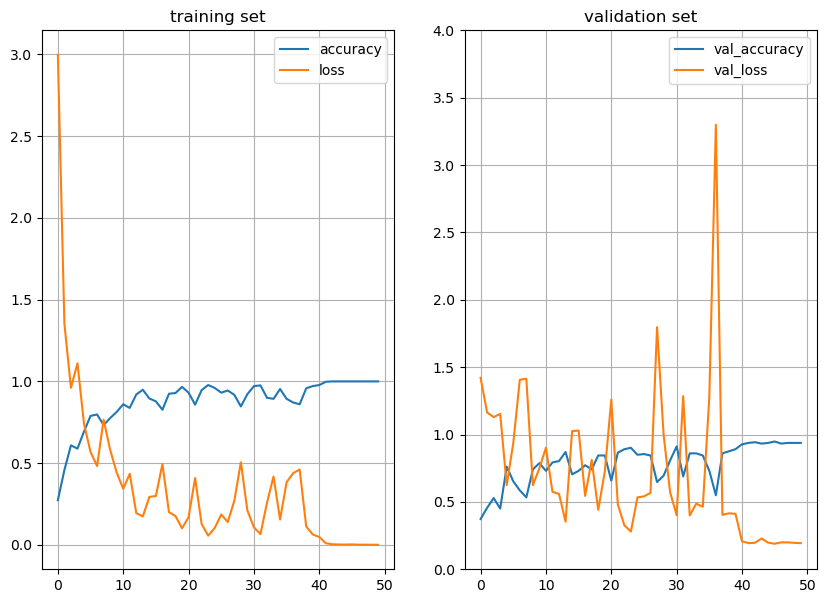

In [57]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['loss'],label='loss')
plt.legend()
plt.title("training set")
plt.grid()
plt.subplot(1,2,2)
plt.plot(hist.history['val_accuracy'],label='val_accuracy')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.legend()
plt.title("validation set")
plt.grid()
plt.ylim((0,4))

### Test Accuracy

In [58]:
score = vggmodel.evaluate(dx_test,y_test)
print("accuracy: ", score[1])

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9737 - loss: 0.1673
accuracy:  0.9751552939414978


In [59]:
pred = vggmodel.predict(dx_test)
prediction = np.argmax(pred,axis=1)
true = np.argmax(y_test,axis=1)
best_prob = [pred[num,:][i] for num,i in enumerate(prediction)]

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


### Confusion Matrix

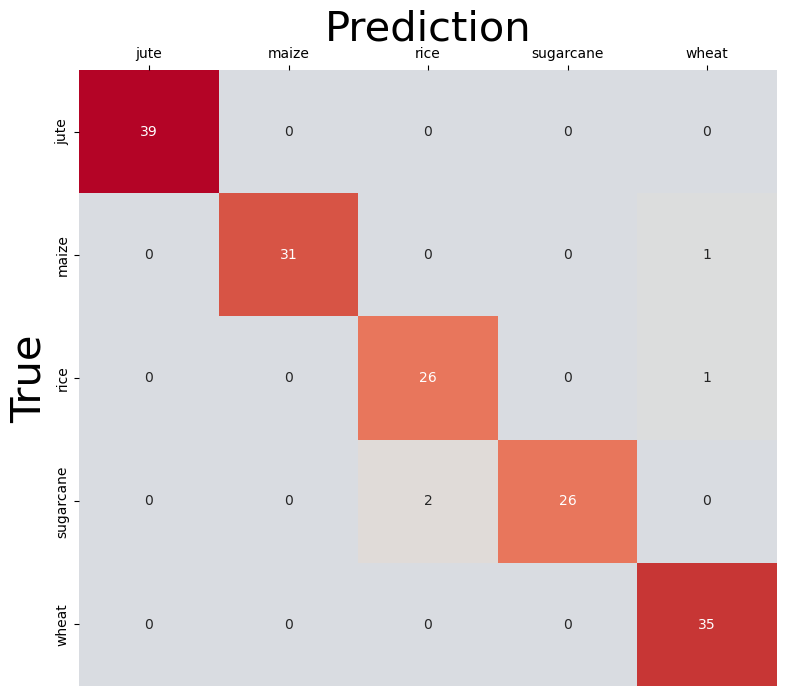

In [60]:
plt.figure(figsize = (9,8))
class_label = ['jute','maize','rice','sugarcane','wheat']
fig = sns.heatmap(confusion_matrix(true,prediction),cmap= "coolwarm",annot=True,vmin=0,cbar = False,
            center = True,xticklabels=class_label,yticklabels=class_label)
fig.set_xlabel("Prediction",fontsize=30)
fig.xaxis.set_label_position('top')
fig.set_ylabel("True",fontsize=30)
fig.xaxis.tick_top()